## CSE 676 Deep Learning Final Project
## Model-2: Image Captioning with Xception + GRU + Soft Attention

Srikar Challa, 50312357 (srikarch@buffalo.edu) <br>
Srisai Karthik Neelamraju, 50316785 (neelamra@buffalo.edu) <br>
Anantha Srinath Sedimbi, 50315869 (asedimbi@buffalo.edu)

### Importing the required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import xception, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.nn import relu, softmax, tanh
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
import nltk
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading the Flickr 8K dataset

In [0]:
try:
    captions = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/captions.p", "rb"))
    captions_dict = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/captions_dict.p", "rb"))
    image_names = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/image_names.p", "rb"))
except:
    images_path = '/content/gdrive/My Drive/flickr8k/flickr8k-images/'
    captions_path = '/content/gdrive/My Drive/flickr8k/flickr8k-captions.txt'
    captions_file = open(captions_path, 'r')
    captions = []
    captions_dict = {}
    image_names = []
    for line in captions_file:
        spl = line.split('\t')
        img_name = images_path + spl[0].split('#')[0]
        caption = '<start> ' + spl[1].split('.')[0].strip() + ' <end>'
        captions.append(caption)
        image_names.append(img_name)
        if img_name in captions_dict:
            captions_dict[img_name].append(spl[1].split('.')[0].strip().split(' '))
        else:
            captions_dict[img_name] = [spl[1].split('.')[0].strip().split(' ')]
    pickle.dump(captions, open("/content/gdrive/My Drive/flickr8k_checkpoints/captions.p", "wb"))
    pickle.dump(captions_dict, open("/content/gdrive/My Drive/flickr8k_checkpoints/captions_dict.p", "wb"))
    pickle.dump(image_names, open("/content/gdrive/My Drive/flickr8k_checkpoints/image_names.p", "wb"))

### Preprocessing the images in the dataset

In [0]:
def preprocess(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = xception.preprocess_input(img)
    return img, image_path

# defining pre-trained Xception model
Xception_ = Xception(include_top=False, weights='imagenet')
xception_model = Model(Xception_.input, Xception_.output)

# # extracting image features from Xception network
# # features are written to disk
# img_names = list(captions_dict.keys())
# image_dataset = tf.data.Dataset.from_tensor_slices(img_names)
# image_dataset = image_dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
# for img, path in image_dataset:
#     batch_features = xception_model(img)
#     batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode('utf-8')
#         np.save(path_of_feature, bf.numpy())

### Tokenizing the captions and splitting the dataset

In [0]:
tokenizer = Tokenizer(num_words=5000, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
sequences = tokenizer.texts_to_sequences(captions)
max_len = max(len(seq) for seq in sequences)
captions_padded = pad_sequences(sequences, padding='post', maxlen=max_len)

# splitting the dataset
img_names_train, img_names_test, captions_train, captions_test = train_test_split(image_names, captions_padded, test_size=0.2, random_state=0)

### Defining the hyperparameters for training the network

In [0]:
batch_size = 64
buffer_size = 1000
embedding_dim = 256
n_gru_units = 512
vocab_size = 5001
n_iter = len(img_names_train) // batch_size

### Defining the neural network model

In [0]:
# CNN-based Encoder
class Encoder(Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = relu(x)
        return x

# Soft Attention Mechanism
class Attention(Model):
    def __init__(self, n_gru_units):
        super(Attention, self).__init__()
        self.W1 = Dense(n_gru_units)
        self.W2 = Dense(n_gru_units)
        self.V = Dense(1)
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# RNN-based Decoder
class Decoder(Model):
    def __init__(self, embedding_dim, n_gru_units, vocab_size):
        super(Decoder, self).__init__()
        self.n_gru_units = n_gru_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(self.n_gru_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = Dense(self.n_gru_units)
        self.fc2 = Dense(vocab_size)
        self.attention = Attention(self.n_gru_units)
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.n_gru_units))

encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, n_gru_units, vocab_size)

### Creating a TensorFlow dataset object of the training set

In [0]:
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_names_train, captions_train))
dataset = dataset.map(lambda x1, x2: tf.numpy_function(map_func, [x1, x2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Defining the loss function

In [0]:
# using Adam Optimizer for the network
optimizer = Adam()
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# custom-loss function
def custom_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    return tf.reduce_mean(loss_ * mask)

### Creating a checkpoint manager for saving the network weights

In [9]:
chkpt_path = '/content/gdrive/My Drive/flickr8k_checkpoints/train'
chkpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
chkpt_manager = tf.train.CheckpointManager(chkpt, chkpt_path, max_to_keep=1)
if chkpt_manager.latest_checkpoint:
    print("Found a checkpoint")
    chkpt.restore(chkpt_manager.latest_checkpoint)

Found a checkpoint


### Training the network

In [0]:
# @tf.function
# def train_step(img_tensor, target):
#     loss = 0
#     hidden = decoder.reset_state(batch_size=target.shape[0])
#     dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
#     with tf.GradientTape() as tape:
#         features = encoder(img_tensor)
#         for i in range(1, target.shape[1]):
#             predictions, hidden, _ = decoder(dec_input, features, hidden)
#             loss += custom_loss(target[:, i], predictions)
#             dec_input = tf.expand_dims(target[:, i], 1)
#         total_loss = (loss / int(target.shape[1]))
#         trainable_variables = encoder.trainable_variables + decoder.trainable_variables
#         gradients = tape.gradient(loss, trainable_variables)
#         optimizer.apply_gradients(zip(gradients, trainable_variables))
#     return loss, total_loss

In [0]:
# try:
#     train_losses = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/losses.p", "rb"))
# except:
#     train_losses = []
# 
# epochs = 100
# start = len(train_losses) + 1
# for ep in range(start, start+epochs):
#     total_loss = 0
#     for (batch, (img_tensor, target)) in enumerate(dataset):
#         batch_loss, t_loss = train_step(img_tensor, target)
#         total_loss += t_loss
#         if batch % 100 == 0:
#             print('Epoch: ' + str(ep) + '\tBatch: ' + str(batch) + '\tLoss: ' + str(batch_loss.numpy()/int(target.shape[1])))
#     train_losses.append(total_loss/n_iter)
#     if ep % 5 == 0 or ep == start + epochs - 1:
#         pickle.dump(train_losses, open("/content/gdrive/My Drive/flickr_8k/losses.p", "wb"))
#         chkpt_manager.save()
#     print('Epoch: ' + str(ep) + '\tLoss: ' + str(total_loss/n_iter))

### Making prediction on a testing set image

In [0]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(preprocess(image)[0], 0)
    img_tensor_val = xception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result
        dec_input = tf.expand_dims([predicted_id], 0)
    return result

Original Image


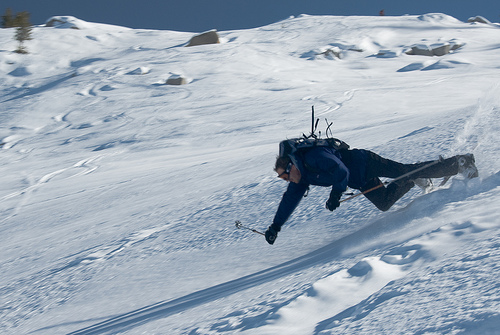

Real Captions:
1. A skier falling down a hill
2. A skier is falling face first into the snow
3. A skier is falling into the snow
4. A skier falls down a hill
5. The skier is leaning forward in the snow
Predicted Caption:
a skier with a trick on the slope


In [16]:
# randomly selecting a testing set image and predicting its caption
test_img = img_names_test[np.random.choice(len(img_names_test))]
pred_caption = evaluate(test_img)

# viewing the original image
print("Original Image")
cv2_imshow(cv2.imread(test_img))

# real captions of the image
print("Real Captions:")
real_captions = [' '.join(captions_dict[test_img][i]) for i in range(5)]
for i in range(5):
    print(str(i+1) + ". " + real_captions[i])

# caption of the image predicted by our model
print("Predicted Caption:")
print(' '.join(pred_caption[0:-1]))

### Computing BLEU scores on the testing set

In [14]:
# PREDICTIONS: finding the predicted captions for all test set images
# type list(list(str))
print("Finding the predictions on the testing set ...", end=' ')
try:
    pred_captions = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/pred_captions.p", "rb"))
except:
    pred_captions = []
    i = 0
    for img in img_names_test:
        i += 1
        if i % 50 == 0:
            pickle.dump(pred_captions, open("/content/gdrive/My Drive/flickr8k_checkpoints/pred_captions.p", "wb"))
        pred_caption = evaluate(img)
        pred_captions.append(pred_caption[1:-1])
print("DONE")

# REFERENCES: aggregating all 5 original captions for all test set images
# type list(list(list(str)))
try:
    ref_list = pickle.load(open("/content/gdrive/My Drive/flickr8k_checkpoints/ref_list.p", "rb"))
except:
    ref_list = []
    for img in img_names_test:
        ref_list.append(captions_dict[img])
    pickle.dump(pred_captions, open("/content/gdrive/My Drive/flickr8k_checkpoints/ref_list.p", "wb"))

# BLEU SCORES: computes BLEU-1, BLEU-2, BLEU-3 and BLEU-4 scores
print("Computing BLEU scores ...", end=' ')
bleu_1 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(1, 0, 0, 0))
bleu_2 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(0, 1, 0, 0))
bleu_3 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(0, 0, 1, 0))
bleu_4 = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_captions, weights=(0, 0, 0, 1))
print("DONE\nBLEU-1\t", bleu_1)
print("BLEU-2\t", bleu_2)
print("BLEU-3\t", bleu_3)
print("BLEU-4\t", bleu_4)

Finding the predictions on the testing set ... DONE
Computing BLEU scores ... DONE
BLEU-1	 0.6894483551213906
BLEU-2	 0.5227826962837301
BLEU-3	 0.40409658568419804
BLEU-4	 0.3188057595053681


#### References

1. https://keras.io/ <br>
2. https://arxiv.org/pdf/1610.02357.pdf <br>
3. https://www.tensorflow.org/tutorials/text/image_captioning <br>
4. https://arxiv.org/pdf/1502.03044.pdf <br>
5. https://www.nltk.org/_modules/nltk/translate/bleu_score.html